Train on 13600 samples, validate on 3400 samples
Epoch 1/30
13600/13600 [==============================] - 0s 17us/sample - loss: 41615.8643 - root_mean_squared_error: 203.9997 - val_loss: 32213.5474 - val_root_mean_squared_error: 179.4813
Epoch 2/30
13600/13600 [==============================] - 0s 5us/sample - loss: 24038.0830 - root_mean_squared_error: 155.0422 - val_loss: 17799.9268 - val_root_mean_squared_error: 133.4164
Epoch 3/30
13600/13600 [==============================] - 0s 5us/sample - loss: 12829.9497 - root_mean_squared_error: 113.2694 - val_loss: 9658.3558 - val_root_mean_squared_error: 98.2769
Epoch 4/30
13600/13600 [==============================] - 0s 5us/sample - loss: 7721.9046 - root_mean_squared_error: 87.8744 - val_loss: 7328.4521 - val_root_mean_squared_error: 85.6064
Epoch 5/30
13600/13600 [==============================] - 0s 5us/sample - loss: 6943.9690 - root_mean_squared_error: 83.3305 - val_loss: 7311.6533 - val_root_mean_squared_error: 85.5082
Epoch 6/30

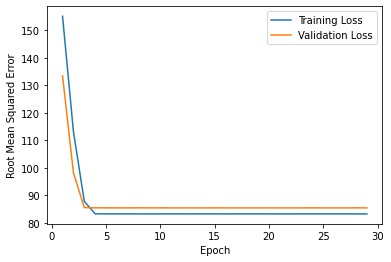

3000/3000 [==============================] - 0s 3us/sample - loss: 7011.5289 - root_mean_squared_error: 83.7349


In [20]:
import numpy as np
import pandas as pd;
import tensorflow as tf;
from tensorflow.keras import optimizers
from matplotlib import pyplot as plt;

# 定义数据格式
pd.options.display.max_rows = 10; # 显示数据时最多显示 10 条，不会对数据本身造成影响
pd.options.display.float_format = "{:.1f}".format; # 数据保留小数点后一位

# 读取数据
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

# scale the training set label
scale_factor = 1000.0;
train_df["median_house_value"] /= scale_factor;
test_df["median_house_value"] /= scale_factor;

# 构建模型
def build_model(my_learning_rate):
    # 定义一个线性模型
    model = tf.keras.models.Sequential();
    # 给 model 添加 layer，这个 layer 有 1 个 unit，有一组 input 输入(第一个参数表示 batch_size，有多少组数据；第二个参数表示 input_size，数据本身大小（矩阵形式）)
    model.add(tf.keras.layers.Dense(units = 1, input_shape = (1,)))
    # 将模型拓扑编译成代码，定义模型的 gradient, loss function, metrics
    # RMSProp 是一种 gradient decent 方法
    # loss function is used to optimize the model
    # metrics is used to judge the performance of your model
    model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                  loss="mean_squared_error",
                  metrics=[tf.keras.metrics.RootMeanSquaredError()]);
    return model;

# 训练模型
def train_model(model, df, feature, label, epochs, batch_size, validation_split):
    history = model.fit(x = df[feature],
                        y = df[label],
                        batch_size = batch_size,
                        epochs = epochs,
                        validation_split = validation_split);
    
    # gather the trained model's weight and bias
    trained_weight = model.get_weights()[0];
    trained_bias = model.get_weights()[1];
        
    # list of epochs
    epochs = history.epoch;
    
    # gather the history of each epoch
    hist = pd.DataFrame(history.history);
    
    # gather the model's root mean square error at each epoch
    rmse = hist["root_mean_squared_error"];
    
    return epochs, rmse, history.history;

# 画出损失
def plot_the_loss_curve(epochs, mae_training, mae_validation):
    plt.figure();
    plt.xlabel('Epoch');
    plt.ylabel('Root Mean Squared Error');
  
    # 剔除第一个 epoch 的数据，因此是 [1:]
    # we are not going to plot the first epoch, because the loss in the first epoch is often substantially greater than other epochs
    plt.plot(epochs[1:], mae_training[1:], label='Training Loss');
    plt.plot(epochs[1:], mae_validation[1:], label='Validation Loss');
    plt.legend();
    
    # 计算图的上下限
    merged_mae_list = mae_training[1:] + mae_validation[1:];
    highest_loss = max(merged_mae_list);
    lowest_loss = min(merged_mae_list);
    
    delta = highest_loss - lowest_loss;
    
    top_of_y_axis = highest_loss + delta * 0.05;
    bottom_of_y_axis = lowest_loss - delta * 0.05;
    
    plt.ylim([bottom_of_y_axis, top_of_y_axis]);
    plt.show();

# 定义参数
learning_rate=0.08;
epochs = 30;
my_batch_size = 100;
validation_split = 0.2

my_feature = "median_income";
my_label = "median_house_value";

# 数据集本身分布不均匀导致 validation loss 始终比 training loss 要大，因此要对数据集做一定的 shuffle
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index));

# 构建模型，训练模型
my_model = build_model(learning_rate);
epochs, rmse, history = train_model(my_model, shuffled_train_df, my_feature, my_label, epochs, my_batch_size, validation_split);

# 画出损失
plot_the_loss_curve(epochs, history["root_mean_squared_error"], history["val_root_mean_squared_error"]);

# 在测试集中验证
x_test = test_df[my_feature];
y_test = test_df[my_label];

results = my_model.evaluate(x_test, y_test, batch_size = my_batch_size);
    